In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

%config InlineBackend.figure_formats = ['svg']
os.chdir('/Users/ngdnh/Codespace/parity-qubit/')

# Physical implementation of a $\cos2\varphi$ qubit 

based on high-transmission Josephson junctions...

### Potentials

Standard tunnel junctions have a potential energy $U(\varphi)=-E_J\cos\varphi$, which in principle, does not have any higher harmonic terms such as $\cos2\varphi$ terms. Junctions with a conduction channel of transmission $\tau$ closer to 1 admit the more general Andreev Bound States (ABS) potential,
\begin{align}
U_\tau(\varphi)=-\Delta\sqrt{1-\tau\sin^2\varphi/2},
\end{align}
providing several higher harmonic terms. The potential is still $2\pi$-periodic and can be expanded in Fourier series,
\begin{align}
U_\tau(\varphi)=-\sum A_k\cos k\varphi
\end{align}
If the junction is tunnel, $\tau$ is small, and only the $\cos\varphi$ term in the expansion is important. When $\tau$ becomes larger, the $\cos2\varphi$ term starts to play a more important role, while still staying smaller than the $\cos\varphi$ term.

We now elucidate these concepts. First, we look at the decomposition of the $U_\tau(\varphi)$. We have assumed that
\begin{align}
U_\tau(\varphi)=-\sum A_k\cos k\varphi,\\
\int_{-\pi}^\pi U_\tau(\varphi)\cos k\varphi d\varphi &= -\sum_{n=0}^\infty A_n\int_{-\pi}^\pi\cos n\varphi \cos k\varphi d\varphi,\\ &= -A_0\int_{-\pi}^\pi \cos k\varphi d\varphi - \sum_{n>0}^\infty A_n\int_{-\pi}^\pi\cos n\varphi \cos k\varphi d\varphi
\end{align}
Note that 
\begin{align}
\int_{-\pi}^\pi\cos n\varphi \cos k\varphi d\varphi = \begin{cases}0, k \neq n,\\
2\pi, k = n = 0,\\
\pi, k = n \neq 0
\end{cases}
\end{align}
Then
\begin{align}
A_0 = -\dfrac{1}{2\pi}\int_{-\pi}^\pi U_\tau(\varphi)d\varphi,\\
A_k = -\dfrac{1}{\pi}\int_{-\pi}^\pi U_\tau(\varphi)\cos k\varphi d\varphi.
\end{align}

In [2]:
def andreev_potential(varphi, tau):
    """ 
    The general Andreev potential.

    """
    return -np.sqrt(1 - tau * np.sin(varphi/2)** 2)

def tunnel_potential(tau, varphi):
    """ 
    Tunneling junction potential, 1st order expansion of Andreev potential.
    """
    return -(tau/4)*np.cos(varphi)-1+tau/4

def cal_A0(tau):
    integral, _ = quad(lambda varphi: andreev_potential(varphi, tau), -np.pi, np.pi)
    A0 = -integral / (2*np.pi)
    return A0

def cal_Ak(k, tau):
    def integrand(varphi):
        return andreev_potential(varphi, tau) * np.cos(k*varphi)
    integral, _ = quad(integrand, -np.pi, np.pi)
    Ak = -integral / np.pi
    return Ak

def reconstructed_potential(varphi, varphi_ext, fourier_decomp):
    """ 
    Compute a potential from Fourier coefficients
    """
    potential = 0
    for k in range(len(fourier_decomp)):
        A_k = fourier_decomp[k]
        potential += - A_k * np.cos(k*(varphi-varphi_ext))
    return potential

We first try a value of $\tau=0.98$. This is quite high. Let $\Delta=1$.

In [3]:
tau_0 = 0.99 # transmission coefficient
Delta_0 = 1 # superconducting gap

In [4]:
varphi_range = np.linspace(-3*np.pi, 3*np.pi, 100)

fourier_decomp = []

A0 = cal_A0(tau_0)
fourier_decomp.append(A0)
num_coefs = 3
for k in range(1, num_coefs+1):
    Ak = cal_Ak(k, tau_0)
    fourier_decomp.append(Ak)

fourier_decomp

[0.6468015793608901,
 0.4082257769824268,
 -0.07445757815645296,
 0.028495485179153984]

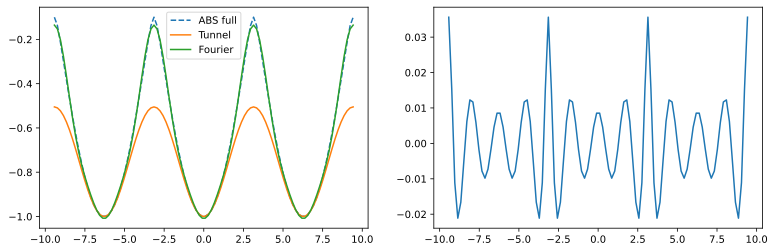

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(13, 4))
axes[0].plot(varphi_range, [andreev_potential(varphi, tau_0) for varphi in varphi_range], linestyle='--', label='ABS full')
axes[0].plot(varphi_range, [tunnel_potential(tau_0, varphi) for varphi in varphi_range], label='Tunnel')
axes[0].plot(varphi_range, [reconstructed_potential(varphi, 0, fourier_decomp) for varphi in varphi_range], label='Fourier')

axes[1].plot(varphi_range, ([andreev_potential(varphi, tau_0)-reconstructed_potential(varphi, 0, fourier_decomp) for varphi in varphi_range]), label='ABS full - Fourier')
axes[0].legend()

Using only 3 terms in the Fourier series, the potential is performing quite good actually. We plot here the $\cos$ at each order.

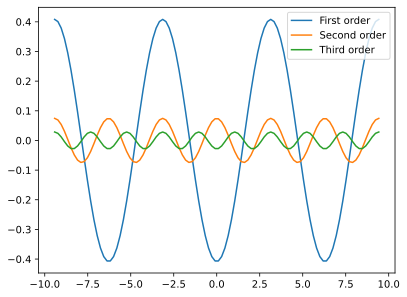

In [6]:
fig, ax = plt.subplots()
ax.plot(varphi_range, - fourier_decomp[1] * np.cos(varphi_range), label='First order')
ax.plot(varphi_range, - fourier_decomp[2] * np.cos(2*varphi_range), label='Second order')
ax.plot(varphi_range, - fourier_decomp[3] * np.cos(3*varphi_range), label='Third order')
ax.legend()

## Using interference

To cancel the dominant first harmonics, we consider a circuit made out of two junctions in parallel, forming a superconducting loop threaded by an external magnetic field $\Phi_{\text{ext}}$. Let the phase differences across the two junctions be $\varphi_1$ and $\varphi_2$. The external flux introduces a constraint on the total phase around the loop due to flux quantization,
\begin{align}
\varphi_2-\varphi_1 = 2\pi \dfrac{\Phi_{ext}}{\Phi_0}=\varphi_\text{ext}
\end{align}
where $\Phi_0=h/(2e)$ is the flux quantum. We make one small modification to the previous Andreev Bound State potential: previously, there's only one conduction channel. Here we consider $N_c$ conduction channels. The ABS potential reads,
\begin{align}
U/\Delta&=-\sum_{i=1}^{N_c} \sqrt{1-\tau_{1,i}\sin^2\frac{\varphi_1}{2}} - \sqrt{1-\tau_{2,i}\sin^2\frac{\varphi_2}{2}},\\
&=-\sum_{i=1}^{N_c} \sqrt{1-\tau_{1,i}\sin^2\frac{\varphi_1}{2}} - \sqrt{1-\tau_{2,i}\sin^2\frac{\varphi_1+\varphi_{ext}}{2}},\\
&\approx-\sum_{k=1}^{k_{max}} \left(A^{(1)}_k\cos k\varphi_1+A^{(2)}_k\cos[k(\varphi_1+\varphi_{ext})]\right)
\end{align}

In [7]:
taus_data = np.load('./all_taus.npz')
taus_data

NpzFile './all_taus.npz' with keys: Al04, Al22, Al38, MAR01B15, MAR02AC3...

In [8]:
pinJJdata = np.load('./pinJJdata.npz')
pinJJdata

NpzFile './pinJJdata.npz' with keys: V1, I1, V2, I2, V3...

In [9]:
pinJJdata.files

['V1',
 'I1',
 'V2',
 'I2',
 'V3',
 'I3',
 'Vtunnel',
 'Itunnel',
 'V1_fit',
 'I1_fit',
 'V2_fit',
 'I2_fit',
 'V3_fit',
 'I3_fit',
 'taus1',
 'taus2',
 'taus3']

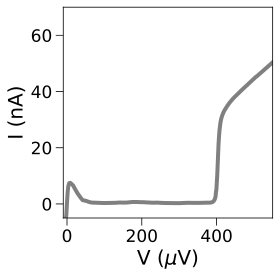

In [76]:
fig, ax = plt.subplots(figsize=(4, 4))

# ax.plot(pinJJdata['V1']/1e-6,pinJJdata['I1']/1e-9, linewidth=3, color='tab:blue')
# ax.plot(pinJJdata['V2']/1e-6,pinJJdata['I2']/1e-9, linewidth=3, color='tab:orange')
# ax.plot(pinJJdata['V3']/1e-6,pinJJdata['I3']/1e-9, linewidth=3, color='tab:green')
ax.plot(pinJJdata['Vtunnel']/1e-6,pinJJdata['Itunnel']/1e-9, color='gray', linewidth=4)


# ax.plot(pinJJdata['V1_fit']/1e-6,pinJJdata['I1_fit']/1e-9, linewidth=4, color='tab:blue')
# ax.plot(pinJJdata['V2_fit']/1e-6,pinJJdata['I2_fit']/1e-9, linewidth=4, color='tab:orange')
# ax.plot(pinJJdata['V3_fit']/1e-6,pinJJdata['I3_fit']/1e-9, linewidth=4, color='tab:green')

ax.tick_params(axis='x', which='major', length=7.5)
ax.tick_params(axis='y', which='major', length=7.5)
ax.tick_params(axis='y', labelsize=17)
ax.tick_params(axis='x', labelsize=17)

ax.set_xlim(-10, 550)
ax.set_ylim(-5, 70)

ax.set_xlabel(r'V ($\mu$V)', fontsize=20)
ax.set_ylabel(r'I (nA)', fontsize=20)
fig.tight_layout()

fig.savefig('./tunnel.png', transparent=True, dpi=1000)

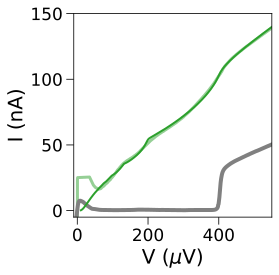

In [86]:
fig, ax = plt.subplots(figsize=(4, 4))

# ax.plot(pinJJdata['V1']/1e-6,pinJJdata['I1']/1e-9, linewidth=4, color='tab:blue', alpha=0.5)
# ax.plot(pinJJdata['V2']/1e-6,pinJJdata['I2']/1e-9, linewidth=3, color='tab:orange', alpha=0.5)
ax.plot(pinJJdata['V3']/1e-6,pinJJdata['I3']/1e-9, linewidth=3, color='tab:green', alpha=0.5)
ax.plot(pinJJdata['Vtunnel']/1e-6,pinJJdata['Itunnel']/1e-9, color='gray', linewidth=4)


# ax.plot(pinJJdata['V1_fit']/1e-6,pinJJdata['I1_fit']/1e-9, linewidth=2, color='tab:blue')
# ax.plot(pinJJdata['V2_fit']/1e-6,pinJJdata['I2_fit']/1e-9, linewidth=2, color='tab:orange')
ax.plot(pinJJdata['V3_fit']/1e-6,pinJJdata['I3_fit']/1e-9, linewidth=2, color='tab:green')

ax.tick_params(axis='x', which='major', length=7.5)
ax.tick_params(axis='y', which='major', length=7.5)
ax.tick_params(axis='y', labelsize=17)
ax.tick_params(axis='x', labelsize=17)

ax.set_xlim(-10, 550)
ax.set_ylim(-5, 150)

ax.set_xlabel(r'V ($\mu$V)', fontsize=20)
ax.set_ylabel(r'I (nA)', fontsize=20)
fig.tight_layout()

fig.savefig('./pin3.png', transparent=True, dpi=1000)

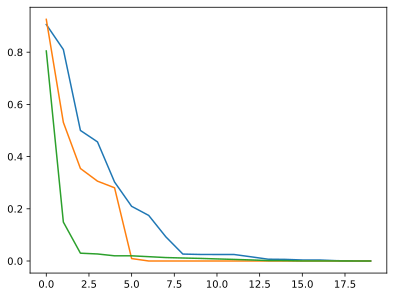

In [9]:
plt.plot(taus_data['Al04'])
plt.plot(taus_data['Al22'])
plt.plot(taus_data['Al38'])

In [10]:
def generalized_ABS(varphi, N_c, phi_ext, taus):
    """ 
    Calculate the generalized Andreev Bound State potential for a junction with several conduction channels
    """
    U = 0
    for i in range(N_c):
        U += np.sqrt(1 - taus[i]*np.sin((phi_ext+varphi)/2)**2)

    return - U

In [11]:
def cal_A0(N_c, phi_ext, taus):
    integral, _ = quad(lambda varphi: generalized_ABS(varphi, N_c, phi_ext, taus), -np.pi, np.pi)
    A0 = -integral / (2*np.pi)
    return A0

def cal_Ak(k, N_c, phi_ext, taus):
    def integrand(varphi):
        return generalized_ABS(varphi, N_c, phi_ext, taus) * np.cos(k*(varphi+phi_ext))
    integral, _ = quad(integrand, -np.pi, np.pi)
    Ak = -integral / np.pi
    return Ak

def Ak_list(N_c, phi_ext, taus, num_coefs):
    fourier_decomp = []
    A0 = cal_A0(N_c, phi_ext, taus)
    fourier_decomp.append(A0)
    for k in range(1, num_coefs+1):
        Ak = cal_Ak(k, N_c, phi_ext, taus)
        fourier_decomp.append(Ak)
    return fourier_decomp

def reconstructed_potential(varphi, varphi_ext, fourier_decomp):
    """ 
    Compute a potential from Fourier coefficients
    """
    potential = 0
    for k in range(len(fourier_decomp)):
        A_k = fourier_decomp[k]
        potential += - A_k * np.cos(k*(varphi+varphi_ext))
    return potential

In [12]:
Ak_list_Al04 = Ak_list(N_c=len(taus_data['Al04']), phi_ext=0, taus=taus_data['Al04'], num_coefs=5)
Ak_list_Al04_2 = Ak_list(N_c=len(taus_data['Al04']), phi_ext=np.pi, taus=taus_data['Al04'], num_coefs=5)
Ak_list_Al22 = Ak_list(N_c=len(taus_data['Al22']), phi_ext=np.pi, taus=taus_data['Al22'], num_coefs=5)
Ak_list_Al38 = Ak_list(N_c=len(taus_data['Al38']), phi_ext=0, taus=taus_data['Al38'], num_coefs=5)

Ak_list_Al04, Ak_list_Al22, Ak_list_Al38

([18.940267784721968,
  1.1300246233946798,
  -0.08383091383130167,
  0.017291613111804306,
  -0.004993878322266276,
  0.001695237827225882],
 [19.28530446669869,
  0.7648685178054623,
  -0.06095841265133518,
  0.014237223730258803,
  -0.004765241319579004,
  0.001860863977323684],
 [19.667238127451252,
  0.35512574943201924,
  -0.02639894153877842,
  0.004979615509443759,
  -0.001195210713533124,
  0.0003223690316232436])

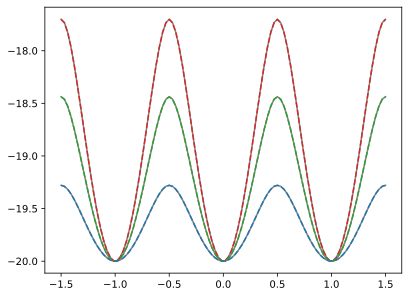

In [13]:
varphi_range = np.linspace(-3*np.pi, 3*np.pi, 100)

fig, ax = plt.subplots()
ax.plot(varphi_range/(2*np.pi), [generalized_ABS(varphi, N_c=len(taus_data['Al04']), phi_ext=0, taus=taus_data['Al04']) for varphi in varphi_range], color='tab:gray')
ax.plot(varphi_range/(2*np.pi), [generalized_ABS(varphi, N_c=len(taus_data['Al22']), phi_ext=0, taus=taus_data['Al22']) for varphi in varphi_range], color='tab:gray')
ax.plot(varphi_range/(2*np.pi), [generalized_ABS(varphi, N_c=len(taus_data['Al38']), phi_ext=0, taus=taus_data['Al38']) for varphi in varphi_range], color='tab:gray')

ax.plot(varphi_range/(2*np.pi), [reconstructed_potential(varphi, 0, fourier_decomp=Ak_list_Al04) for varphi in varphi_range], linestyle='--', color='tab:red')
ax.plot(varphi_range/(2*np.pi), [reconstructed_potential(varphi, 0, fourier_decomp=Ak_list_Al22) for varphi in varphi_range], linestyle='--', color='tab:green')
ax.plot(varphi_range/(2*np.pi), [reconstructed_potential(varphi, 0, fourier_decomp=Ak_list_Al38) for varphi in varphi_range], linestyle='--', color='tab:blue')

Let us make a circuit out of the two junctions `Alxx` and `Alxx`. We're interested in the way odd and even terms in their potential interfere.

In [14]:
def visualize_phasors(amplitudes, phases, k):
    """
    Visualize the phasor representation of sinusoidal components.
    """
    amplitudes = np.array(amplitudes)
    phases = np.array(phases)
    phasors = amplitudes * np.exp(1j * k * phases)
    resultant = np.sum(phasors)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax = plt.gca()

    r = 0 + 0j
    for phasor in phasors:
        next_position = r + phasor
        plt.quiver(r.real, r.imag, 
                   phasor.real, phasor.imag, 
                   angles='xy', scale_units='xy', scale=1, color='tab:blue', alpha=0.2)
        r = next_position

    plt.quiver(0, 0, resultant.real, resultant.imag, angles='xy', scale_units='xy', scale=1, color='tab:green')

    max_amplitude = np.sum(amplitudes)
    ax.set_xlabel('Real')
    ax.set_ylabel('Imag')
    ax.set_xlim(-max_amplitude, max_amplitude)
    ax.set_ylim(-max_amplitude, max_amplitude)
    ax.grid()
    fig.gca().set_aspect('equal', adjustable='box')
    fig.tight_layout()
    print(np.abs(resultant))

6.803569110842653e-16
0.1676618276626013


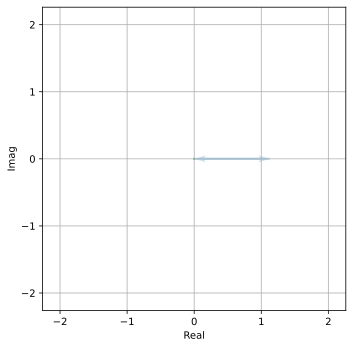

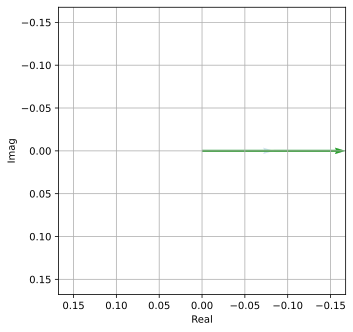

In [15]:
amplitudes = [Ak_list_Al04[1], Ak_list_Al04_2[1]]
phases = [0, np.pi]
visualize_phasors(amplitudes, phases, k = 1)
amplitudes = [Ak_list_Al04[2], Ak_list_Al04_2[2]]
phases = [0, np.pi]
visualize_phasors(amplitudes, phases, k=2)

We have here the potential of the circuit

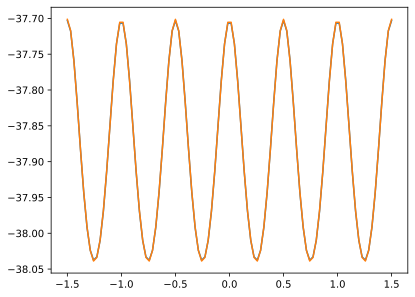

In [16]:
U_2junctions = np.array([reconstructed_potential(varphi, 0, fourier_decomp=Ak_list_Al04)+reconstructed_potential(varphi, np.pi, fourier_decomp=Ak_list_Al04_2) for varphi in varphi_range])

plt.plot(varphi_range/(2*np.pi), U_2junctions)
plt.plot(varphi_range/(2*np.pi), [generalized_ABS(varphi, N_c=len(taus_data['Al04']), phi_ext=0, taus=taus_data['Al04'])+generalized_ABS(varphi, N_c=len(taus_data['Al04']), phi_ext=np.pi, taus=taus_data['Al04']) for varphi in varphi_range])

We use QuTiP to construct the corresponding Hamiltonian,

\begin{align}
H &= 4E_C(N-N_g)^2 - U_{\vec{\tau},\Phi_{ext}}(\varphi_1, \varphi_2),\\
&=4E_C(N-N_g)^2 - \sum_{k=1}^{k_{max}} [A_k^{(1)}\cos k\varphi_1+A_k^{(2)}\cos k\varphi_2],\\
&=4E_C(N-N_g)^2 - \sum_{k=1}^{k_{max}} [A_k^{(1)}\cos k\varphi_1+A_k^{(2)}\cos k(\varphi_1-\Phi_{ext})].
\end{align}

We now envision a circuit made of four junctions in parallel, making three superconducting loops. We let the magnetic flux threading through these three superconducing loops. The potential energy can be written as 
\begin{align}
U(\varphi)&=-\sum_{i=1}^4\sum_{k>0} A_{k}^{(i)}\cos[k(\varphi-\varphi_i)],
\end{align}
where $\varphi_1=0, \varphi_2=2\pi\Phi_A/\Phi_0, \varphi_3=2\pi(\Phi_A+\Phi_B)/\Phi_0, \varphi_4=2\pi(\Phi_A+\Phi_B+\Phi_C)/\Phi_0$. 

Since we need 4 junctions, let's make up one more.

In [17]:
taus_data_made_up = []

for i in range(len(taus_data['Al04'])):
    taus_data_made_up.append(np.mean(taus_data['Al04'][i]+taus_data['Al22'][i]+taus_data['Al38'][i]))

taus_data_made_up = np.array(taus_data_made_up)/3

In [18]:
Ak_list_Al04 = Ak_list(N_c=len(taus_data['Al04']), phi_ext=0, taus=taus_data['Al04'], num_coefs=5)
Ak_list_Al22 = Ak_list(N_c=len(taus_data['Al22']), phi_ext=0, taus=taus_data['Al22'], num_coefs=5)
Ak_list_Al38 = Ak_list(N_c=len(taus_data['Al38']), phi_ext=0, taus=taus_data['Al38'], num_coefs=5)
Ak_list_madeup = Ak_list(N_c=len(taus_data_made_up), phi_ext=0, taus=taus_data_made_up, num_coefs=5)


Ak_list_Al04
Ak_list_Al22
Ak_list_Al38
Ak_list_madeup

[19.314261510637007,
 0.7254849557261291,
 -0.047183306587781804,
 0.009474283873943237,
 -0.002696819093463534,
 0.0008926650304399626]

In [19]:
fourier_decomp_list = np.array([Ak_list_Al04, Ak_list_Al22, Ak_list_Al38, Ak_list_madeup])

0.2201715953967224


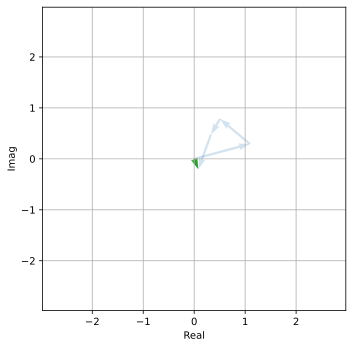

In [20]:
amplitudes = [Ak_list_Al04[1], Ak_list_Al22[1], Ak_list_Al38[1], Ak_list_madeup[1]]
d1, d2, d3, d4 = 15, 140, 240, 250
phases = [d1*np.pi/180, d2*np.pi/180, d3*np.pi/180, d4*np.pi/180]
visualize_phasors(amplitudes, phases, k = 1)

In [21]:
phases

[0.2617993877991494, 2.443460952792061, 4.1887902047863905, 4.363323129985823]

In [22]:
import numpy as np
from scipy.optimize import minimize

k = 1.0

def my_function(phases, amplitudes=amplitudes, k=1.0):
    phasors = amplitudes*np.exp(1j * k * phases)
    resultant = np.sum(phasors)
    return np.abs(resultant)

def objective(phases, k=1.0):
    return my_function(phases, k=k)

if __name__ == "__main__":
    n = 4
    init_phs = phases
    bounds = [(0, 2*np.pi)] * n

    res = minimize(
        fun=objective,
        x0=init_phs,
        args=(k,),
        method="Nelder-Mead",
        bounds=bounds,
        options={"disp": True}
    )

    opt_phs = res.x

    print("Optimized phases:", opt_phs)
    print("Minimum cost:", res.fun)

Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 62
         Function evaluations: 118
Optimized phases: [0.28303889 2.28255084 4.34044704 4.03194448]
Minimum cost: 1.4075445614244816e-05


1.4075445614244816e-05


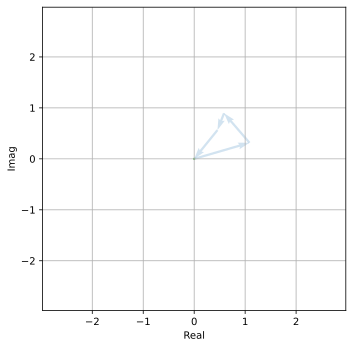

In [23]:
amplitudes = [Ak_list_Al04[1], Ak_list_Al22[1], Ak_list_Al38[1], Ak_list_madeup[1]]
phases = opt_phs
visualize_phasors(amplitudes, phases, k = 1)

0.05856539238654025


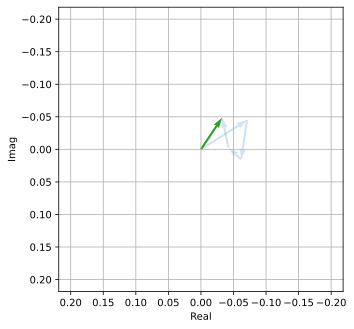

In [24]:
amplitudes = [Ak_list_Al04[2], Ak_list_Al22[2], Ak_list_Al38[2], Ak_list_madeup[2]]
phases = opt_phs
visualize_phasors(amplitudes, phases, k = 2)

0.04080027672277375


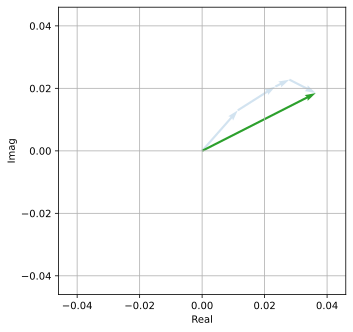

In [25]:
amplitudes = [Ak_list_Al04[3], Ak_list_Al22[3], Ak_list_Al38[3], Ak_list_madeup[3]]
phases = opt_phs
visualize_phasors(amplitudes, phases, k = 3)

0.006010641757037981


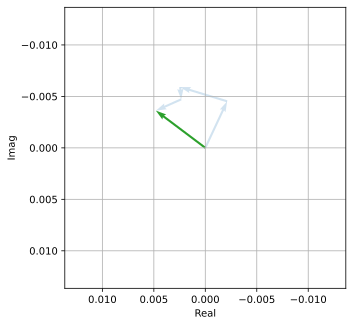

In [26]:
k0 =4 
amplitudes = [Ak_list_Al04[k0], Ak_list_Al22[k0], Ak_list_Al38[k0], Ak_list_madeup[k0]]
phases = opt_phs
visualize_phasors(amplitudes, phases, k = k0)

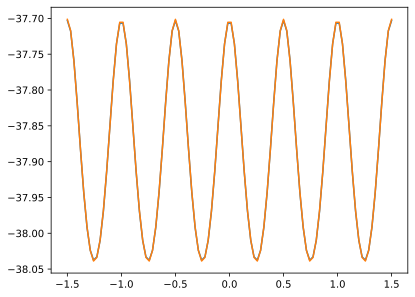

In [27]:
U_2junctions = np.array([reconstructed_potential(varphi, 0, fourier_decomp=Ak_list_Al04)+reconstructed_potential(varphi, np.pi, fourier_decomp=Ak_list_Al04_2) for varphi in varphi_range])

plt.plot(varphi_range/(2*np.pi), U_2junctions)
plt.plot(varphi_range/(2*np.pi), [generalized_ABS(varphi, N_c=len(taus_data['Al04']), phi_ext=0, taus=taus_data['Al04'])+generalized_ABS(varphi, N_c=len(taus_data['Al04']), phi_ext=np.pi, taus=taus_data['Al04']) for varphi in varphi_range])

In [28]:
phases

array([0.28303889, 2.28255084, 4.34044704, 4.03194448])

In [29]:
U_4_list = []

for varphi in varphi_range:
    U_4 = 0
    for i in range(4):
        U_4 += reconstructed_potential(varphi, phases[i], fourier_decomp=fourier_decomp_list[i])
    U_4_list.append(U_4)

U_4_list = np.array(U_4_list)

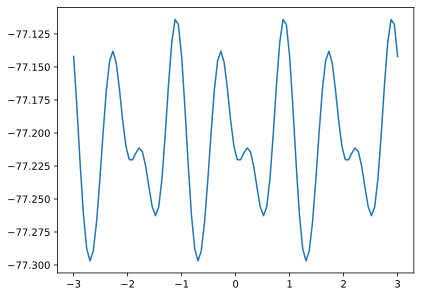

In [30]:
plt.plot(varphi_range/np.pi, U_4_list)

### Completely symmetric junctions

3.1401849173675503e-16


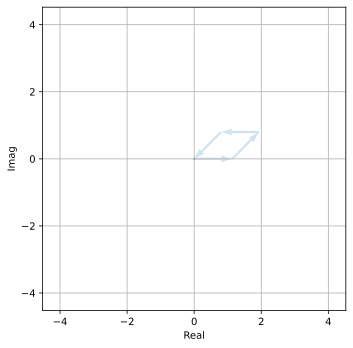

In [31]:
amplitudes = [Ak_list_Al04[1]]*4
d1, d2, d3, d4 = 0, 45, 180, 225
phases = [d1*np.pi/180, d2*np.pi/180, d3*np.pi/180, d4*np.pi/180]
visualize_phasors(amplitudes, phases, k = 1)

0.23710963057271423


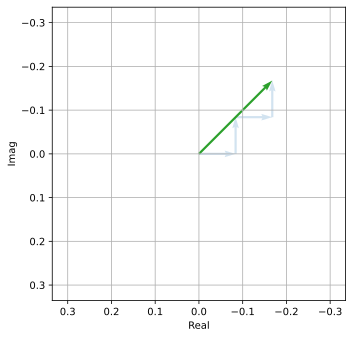

In [32]:
amplitudes = [Ak_list_Al04[2]]*4
d1, d2, d3, d4 = 0, 45, 180, 225
phases = [d1*np.pi/180, d2*np.pi/180, d3*np.pi/180, d4*np.pi/180]
visualize_phasors(amplitudes, phases, k = 2)

1.7860071305544555e-17


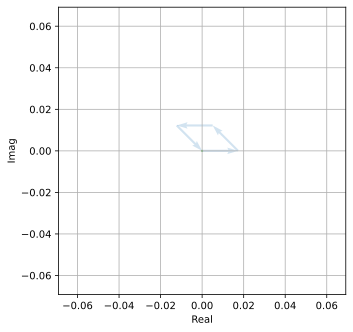

In [33]:
amplitudes = [Ak_list_Al04[3]]*4
d1, d2, d3, d4 = 0, 45, 180, 225
phases = [d1*np.pi/180, d2*np.pi/180, d3*np.pi/180, d4*np.pi/180]
visualize_phasors(amplitudes, phases, k = 3)

In [34]:
U_4_list = []

for varphi in varphi_range:
    U_4 = 0
    for i in range(4):
        U_4 += reconstructed_potential(varphi, phases[i], fourier_decomp=Ak_list_Al04)
    U_4_list.append(U_4)

U_4_list = np.array(U_4_list)

In [35]:
varphi_2 = phases[1]
varphi_3 = phases[2] - varphi_2
varphi_4 = phases[3] - varphi_3

In [36]:
varphi_3

2.356194490192345

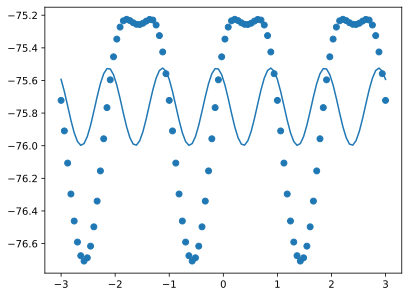

In [37]:
plt.plot(varphi_range/np.pi, U_4_list)
plt.scatter(varphi_range/np.pi, [(generalized_ABS(varphi, N_c=20, phi_ext=0, taus=taus_data['Al04']) \
                              + generalized_ABS(varphi, N_c=20, phi_ext=varphi_2, taus=taus_data['Al04']) + \
                              + generalized_ABS(varphi, N_c=20, phi_ext=varphi_2+2.0, taus=taus_data['Al04']) + \
                              + generalized_ABS(varphi, N_c=20, phi_ext=2.0+varphi_4, taus=taus_data['Al04'])) for varphi in varphi_range])

In [38]:
varphi_range = np.linspace(-3.5, 3.5, 120)

In [39]:
import numpy as np

def v_array_linspace(N):
    if N % 2 == 0:
        raise ValueError("For an exact middle = 1, N must be odd.")
    half = N // 2
    left  = np.linspace(1, 1, half+1)     # includes the central 1
    right = left[:-1][::-1]               # mirror, dropping the duplicate center
    return np.concatenate([left, right])

# Example
scale = v_array_linspace(121)

In [40]:
second_axis_list = []
for idx, phi in enumerate(np.linspace(varphi_3-0.2*varphi_3, varphi_3+0.2*varphi_3, 121)):
    potential_list = []
    potential = 0
    for varphi in varphi_range:
        potential = scale[idx]*(generalized_ABS(varphi, N_c=20, phi_ext=0, taus=taus_data['Al04']) \
                              + generalized_ABS(varphi, N_c=20, phi_ext=varphi_2, taus=taus_data['Al04']) + \
                              + generalized_ABS(varphi, N_c=20, phi_ext=varphi_2+phi, taus=taus_data['Al04']) + \
                              + generalized_ABS(varphi, N_c=20, phi_ext=phi+varphi_4, taus=taus_data['Al04']))
        potential_list.append(potential)
    second_axis_list.append(potential_list)

second_axis_list = np.array(second_axis_list)

In [41]:
X = np.linspace(varphi_3-0.2*varphi_3, varphi_3+0.2*varphi_3, 121)
Y = varphi_range
Z = second_axis_list

In [42]:
second_axis_list.shape

(121, 120)

In [43]:
X_reshaped = np.tile(X, (len(Y), 1)).T
Y_reshaped = np.tile(Y, (len(X), 1))

In [44]:
X_reshaped.shape, Y_reshaped.shape

((121, 120), (121, 120))

In [171]:
X1_small = np.linspace(varphi_3-0.0001*varphi_3, varphi_3+0.0001*varphi_3, 121)
Y1_small = varphi_range

X1_small_reshaped = np.tile(X1_small, (len(Y1_small), 1)).T
Y1_small_reshaped = np.tile(Y1_small, (len(X1_small), 1))

Z1_small = []
for idx, phi in enumerate(X1_small):
    potential_list = []
    potential = 0
    for varphi in Y1_small:
        potential = scale[idx]*(generalized_ABS(varphi, N_c=20, phi_ext=0, taus=taus_data['Al04']) \
                              + generalized_ABS(varphi, N_c=20, phi_ext=varphi_2, taus=taus_data['Al04']) + \
                              + generalized_ABS(varphi, N_c=20, phi_ext=varphi_2+phi, taus=taus_data['Al04']) + \
                              + generalized_ABS(varphi, N_c=20, phi_ext=phi+varphi_4, taus=taus_data['Al04']))
        potential_list.append(potential)
    Z1_small.append(potential_list)

Z1_small = np.array(Z1_small)
sigma_x = 0.47
for idx, varphi in enumerate(Y1_small):
    Z1_small[60][idx] = Z1_small[60][idx] + 1.3*np.exp(-(varphi-Y1_small[27])**2 / (2*sigma_x**2))

# # # # for idx, y in enumerate(Y_small):
# # # #     for jdx, x in enumerate(X_small):
# # # #         Z_Gaussian[jdx][idx] = np.exp(-1*np.abs(Z_Gaussian[jdx][idx]-Z_Gaussian[60][idx]))

In [172]:
X2_small = np.linspace(varphi_3-0.0001*varphi_3, varphi_3+0.0001*varphi_3, 121)
Y2_small = varphi_range

X2_small_reshaped = np.tile(X2_small, (len(Y2_small), 1)).T
Y2_small_reshaped = np.tile(Y2_small, (len(X2_small), 1))

Z2_small = []
for idx, phi in enumerate(X2_small):
    potential_list = []
    potential = 0
    for varphi in Y2_small:
        potential = scale[idx]*(generalized_ABS(varphi, N_c=20, phi_ext=0, taus=taus_data['Al04']) \
                              + generalized_ABS(varphi, N_c=20, phi_ext=varphi_2, taus=taus_data['Al04']) + \
                              + generalized_ABS(varphi, N_c=20, phi_ext=varphi_2+phi, taus=taus_data['Al04']) + \
                              + generalized_ABS(varphi, N_c=20, phi_ext=phi+varphi_4, taus=taus_data['Al04']))
        potential_list.append(potential)
    Z2_small.append(potential_list)

Z2_small = np.array(Z2_small)
sigma_x = 0.47
for idx, varphi in enumerate(Y2_small):
    Z2_small[60][idx] = Z2_small[60][idx] + 1.3*np.exp(-(varphi-Y2_small[83])**2 / (2*sigma_x**2))

# # # # for idx, y in enumerate(Y_small):
# # # #     for jdx, x in enumerate(X_small):
# # # #         Z_Gaussian[jdx][idx] = np.exp(-1*np.abs(Z_Gaussian[jdx][idx]-Z_Gaussian[60][idx]))

In [202]:
Z_plane = np.full((X.shape[0], Y.shape[0]), np.min(second_axis_list))
Z_plane

array([[-76.928, -76.928, -76.928, ..., -76.928, -76.928, -76.928],
       [-76.928, -76.928, -76.928, ..., -76.928, -76.928, -76.928],
       [-76.928, -76.928, -76.928, ..., -76.928, -76.928, -76.928],
       ...,
       [-76.928, -76.928, -76.928, ..., -76.928, -76.928, -76.928],
       [-76.928, -76.928, -76.928, ..., -76.928, -76.928, -76.928],
       [-76.928, -76.928, -76.928, ..., -76.928, -76.928, -76.928]],
      shape=(121, 120))

In [173]:
X1_small_reshaped.shape, Y1_small_reshaped.shape, X2_small_reshaped.shape, Y2_small_reshaped.shape

((121, 120), (121, 120), (121, 120), (121, 120))

In [174]:
Z1_small.shape, Z2_small.shape

((121, 120), (121, 120))

In [212]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

fig = plt.figure(figsize=(15, 18))
ax  = fig.add_subplot(projection='3d')


ax.plot_surface(
    X_reshaped, Y_reshaped, Z,
    rstride=9, cstride=9,
    facecolor='grey', edgecolor='black',
    linewidth=0.2, alpha=0.1,
    shade=False
)

ax.plot_surface(
    X_reshaped, Y_reshaped, Z_plane,
    rstride=20, cstride=20,
    facecolor='grey', edgecolor='grey',
    linewidth=0.10, alpha=0.03,
    shade=False
)


ax.plot_surface(
    X1_small_reshaped, Y1_small_reshaped, Z1_small,
    rstride=1, cstride=1,
    facecolor='#a80000', edgecolor='black',
    linewidth=0, alpha=1,
    shade=False
)

ax.plot_surface(
    X2_small_reshaped, Y2_small_reshaped, Z2_small,
    rstride=1, cstride=1,
    facecolor='#26428b', edgecolor='black',
    linewidth=0, alpha=1,
    shade=False
)

for pane in (ax.xaxis.pane, ax.yaxis.pane, ax.zaxis.pane):
    pane.set_edgecolor('none')     # no edges
    pane.set_facecolor((1,1,1,0))  # fully transparent

ax.grid(False)

# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_zticks([])

ax.set_axis_off()

ax.view_init(elev=20, azim=-57)
ax.set_box_aspect((2, 2, 1))
plt.tight_layout()
plt.savefig('potential.png',dpi=1000, transparent=True)
plt.show()